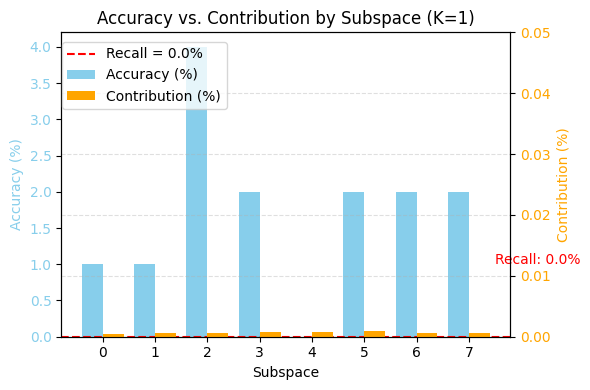

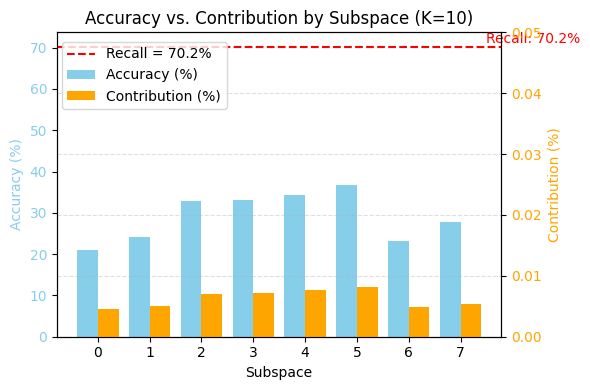

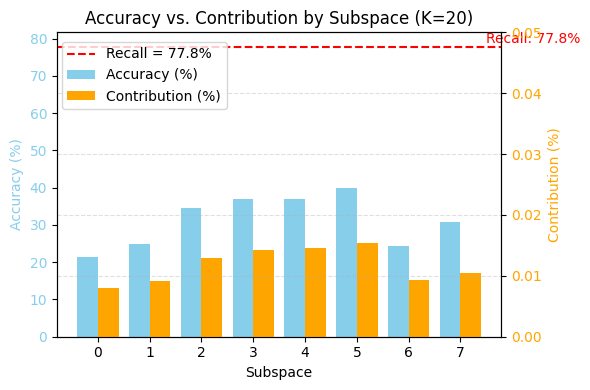

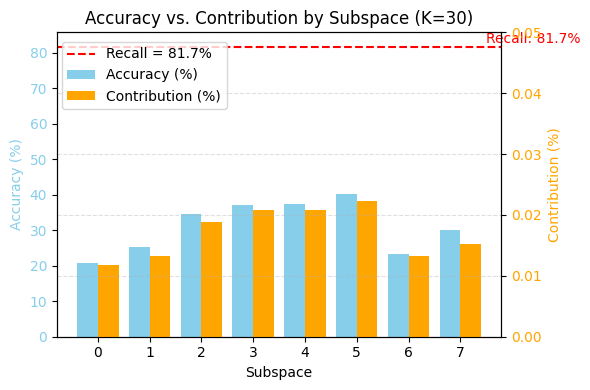

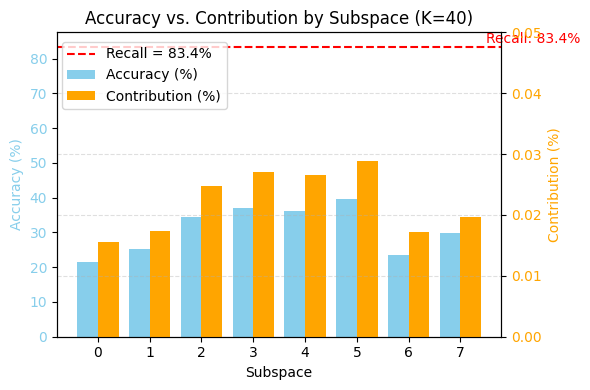

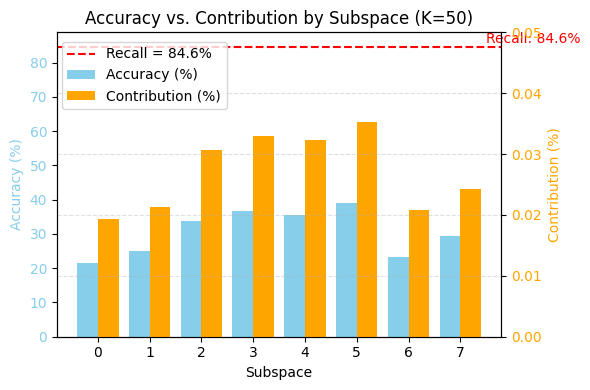

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import re

# 파일 경로
file_path = '/home/sslab/yeojin/SuCo/result/sift10m/sift10m_8_0.05_0.005.txt'

# 파일 읽기
with open(file_path, 'r') as f:
    lines = f.readlines()

# Recall 추출
recall_dict = {}
recall_pattern = re.compile(r"When k = (\d+), \(recall, ratio\) = \(([\d.]+),")
for line in lines:
    match = recall_pattern.search(line)
    if match:
        k = int(match.group(1))
        recall = float(match.group(2)) * 100
        recall_dict[k] = recall

# 데이터 시작점 찾기
data_start_index = -1
for i, line in enumerate(lines):
    if line.strip() == 'k,subspace,accuracy,contribution':
        data_start_index = i + 1
        break

if data_start_index == -1:
    raise ValueError("헤더를 찾을 수 없습니다.")

# 데이터프레임 생성
data_str = "".join(lines[data_start_index:])
df = pd.read_csv(io.StringIO(data_str), header=None, names=['k', 'subspace', 'accuracy', 'contribution'])
df['accuracy'] = df['accuracy'].astype(float)
df['contribution'] = df['contribution'].astype(float)
df['accuracy_percent'] = df['accuracy']
df['contribution_percent'] = df['contribution']

# 고유 K
k_values = sorted(df['k'].unique())

for k in k_values:
    k_df = df[df['k'] == k]
    x = k_df['subspace']
    indices = range(len(x))
    acc = k_df['accuracy_percent']
    contrib = k_df['contribution_percent']

    fig, ax1 = plt.subplots(figsize=(6, 4))

    bar_width = 0.4
    ax1.bar([i - bar_width / 2 for i in indices], acc, width=bar_width, color='skyblue', label='Accuracy (%)')
    ax1.set_ylabel('Accuracy (%)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xlabel('Subspace')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(k_df['subspace'])

    # Recall 라인
    if k in recall_dict:
        recall = recall_dict[k]
        ax1.axhline(y=recall, color='red', linestyle='--', linewidth=1.5, label=f'Recall = {recall:.1f}%')
        ax1.text(len(x)-0.5, recall + 1, f'Recall: {recall:.1f}%', color='red', fontsize=10)

    # 오른쪽 y축
    ax2 = ax1.twinx()
    ax2.bar([i + bar_width / 2 for i in indices], contrib, width=bar_width, color='orange', label='Contribution (%)')
    ax2.set_ylabel('Contribution (%)', color='orange')
    ax2.set_ylim(0, 0.05)
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(f'Accuracy vs. Contribution by Subspace (K={k})')
    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()
